# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Define useful functions

def get_datetimes(df):
    #for converting values in a row to date-times
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')

def make_ts(region): #for making a time series given a zipcode
    ts=small_melt_df2.loc[small_melt_df2.RegionName==region].copy()
    ts=ts[['time','value']]
    ts.set_index('time',inplace=True)
    ts.drop(['RegionID','SizeRank'],axis=0,inplace=True)
    return ts

def make_ts_small(region): #for making a time series given a zip code, using the smallest/narrowed down dataframe
    ts=smallest_df.loc[smallest_df.RegionName==region].copy()
    ts=ts[['time','value']]
    ts.set_index('time',inplace=True)
    ts.drop(['RegionID','SizeRank'],axis=0,inplace=True)
    return ts

def stationarity_check(region_ts): #for determining if a time series is stationary using the Dickey Fuller Test
    steady=None
    tstest=adfuller(region_ts['value'])
    pvalue=tstest[1]
    return pvalue

def melt_data(df):#for converting from wide to long formats
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    #melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

def melt_data2(df): #for converting from wide to long format without aggregating data
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    #melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

def growth_rate(ts):
    #for finding the growth rate between the value in Jan 2015 and the value in Jan 2018
    ts.index=pd.to_datetime(ts.index)
    growth=(float(ts['2018-01']['value'])-float(ts.loc['2015-01']['value']))/float(ts.loc['2015-01']['value'])
    return growth

def detrend(ts):
    #for detrending data with an exponential weighted mean
    exp_rolmean=ts.ewm(halflife=2).mean()
    difference=ts-exp_rolmean
    return difference

def find_arima_parameters(ts): #for finding the best ARIMA paramters assuming a first order model
    p=d=q=range(0,2)
    pdq=list(itertools.product(p,d,q))
    results=[]
    for i in pdq:
        try:
            model=sm.tsa.statespace.SARIMAX(ts['value'],order=i,enforce_stationarity=False,enforce_invertibility=False)
            output=model.fit()
            results.append((i,output.aic))
        except:
            continue
    minAIC=results[0][1]
    for i in results:
        if i[1]>=minAIC:
            continue
        else:
            minAIC=i[1]
            pdq=i[0]
    return pdq,minAIC

def fit_arima(ts,pdq):
    #for fitting the arima model given the parameters
    best_model=sm.tsa.statespace.SARIMAX(ts['value'],order=pdq,enforce_stationarity=False,enforce_invertibility=False)
    output=best_model.fit()
    prediction=output.get_prediction(start=pd.to_datetime('2018-01'),end=pd.to_datetime('2021-01'),dynamic=False)
    return(prediction)

def slope(prediction): #for finding the slope of the predictions
    slope=float(prediction['2021-01-01'])-float(prediction['2018-01-01'])/3
    return slope

def plot_prediction(zipcode,zipcode_ts,prediction): #for plotting data, predictions, and confidence intervals
    pred_conf=prediction.conf_int()
    zipcode_ts.plot(color='grey',label="Observed")
    prediction.predicted_mean.plot(label='Forecast',color='red',alpha=0.7)
    plt.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='blue',alpha=.5)
    plt.title(f'Region {zipcode}')
    plt.xlabel('Date')
    plt.ylabel('Median Property Value')
    plt.legend()
    plt.show()
    return

First, I'll load up the data and take a look at it.

In [3]:
# load the data
df=pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
df.RegionName.value_counts()

55324    1
74561    1
73538    1
31546    1
82070    1
37687    1
67001    1
78643    1
43824    1
84780    1
95019    1
99109    1
35620    1
47906    1
11040    1
44273    1
95003    1
97437    1
37866    1
39702    1
4093     1
78611    1
15122    1
11024    1
82701    1
14225    1
29451    1
61843    1
63369    1
33541    1
        ..
93543    1
13084    1
30116    1
97701    1
56441    1
24017    1
50325    1
11727    1
75214    1
46540    1
48080    1
38344    1
28103    1
97733    1
95684    1
54423    1
64070    1
28071    1
6796     1
67002    1
13304    1
72952    1
32181    1
98057    1
89521    1
75182    1
55343    1
1450     1
73129    1
65536    1
Name: RegionName, Length: 14723, dtype: int64

Looks like each zip code only shows up once.  I notice that there are some 4 digit zip codes listed, though, which is weird since zip codes have 5 digits.  Let's check it out by looking at the first one: 4093.

In [5]:
df.loc[df.RegionName==4093]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
9265,59362,4093,Buxton,ME,Portland,York,9266,NaN,NaN,NaN,...,219500,222500,223600,222700,222500,223100,224000,225100,226900,228800


Maybe it's a typo?  I'm going to look up the city to see if it shows up in other entries but with a different zip code.

In [6]:
df.loc[df.City=='Buxton']

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
9265,59362,4093,Buxton,ME,Portland,York,9266,NaN,NaN,NaN,...,219500,222500,223600,222700,222500,223100,224000,225100,226900,228800


Nope, that's the only entry.  Time to use other resources.

Googling the zip code for Buxton, ME gives me 04903, which makes sense because the dataframe has the zip codes as integers so there's no reason to show that leading zero.  So, it's probably safe to assume that any 4 digit zip codes in this dataframe actually start with a zero.

# Step 2: Data Preprocessing

I'm going to go ahead and change the date columns into datetimes.

In [7]:
df.columns.values[7:]=get_datetimes(df) #changing the columns to datetimes
type(df.columns.values[7]) #checking a column to make sure the data type changed

pandas._libs.tslibs.timestamps.Timestamp

There are a lot of columns to look at in this dataframe so, instead of getting a table with all the missing values, I'm just going to make a graph to see which columns are missing data.

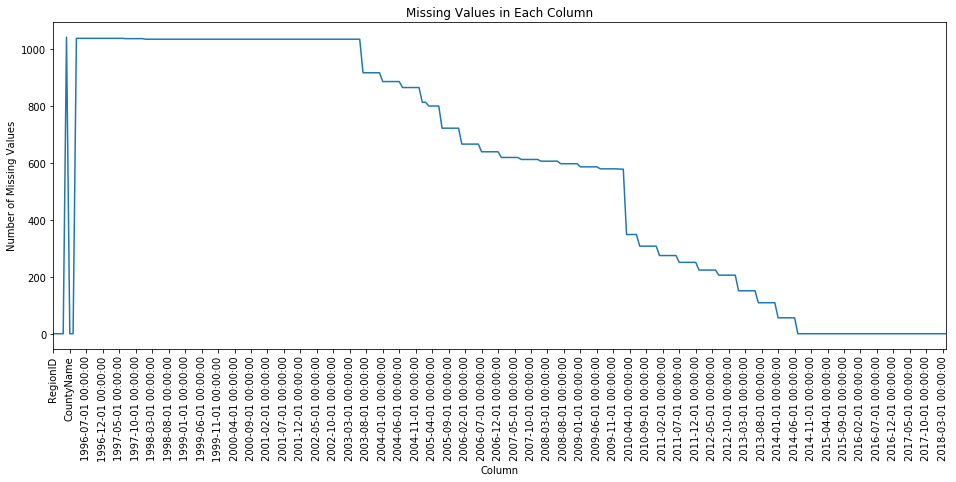

In [8]:
df.isna().sum().plot(figsize=(16,6))
plt.title("Missing Values in Each Column")
plt.xlabel('Column')
plt.xticks(rotation=90,ticks=range(0,len(df.columns),5),labels=df.columns[0::5])
plt.ylabel('Number of Missing Values');

It's easy to see that the older dates are missing more values while the newer dates (from 2014 onwards) aren't missing any data.  I'm not going to do anything about that yet but I'll keep it in mind for later.  I'm curious to see what the other missing values are so I'm just going to look at the non-date columns now.

In [9]:
df.isna().sum().head(7)

RegionID         0
RegionName       0
City             0
State            0
Metro         1043
CountyName       0
SizeRank         0
dtype: int64

In [10]:
print(f'{round(df.Metro.isna().sum()/len(df),2)}% of the Metro values are missing.')

0.07% of the Metro values are missing.


In [11]:
df.Metro.head()

0              Chicago
1    Dallas-Fort Worth
2              Houston
3              Chicago
4              El Paso
Name: Metro, dtype: object

Looks like the `Metro` column keeps track of what metropolitan area the zip code refers to.  The missing values might be due to a lack of data or it might be that the zip code doesn't actually fall into a particular metropolitan area.  Since the scope of this project focuses on investing in zipcodes rather than metropolitan areas, I'm just going to ignore this column for now.  It could be interesting for futher work though.

# Step 3: EDA and Visualization

In [12]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

I'm curious to see what some of the data looks like.  There are 14000 zip codes in the dataframe so that'd be a crazy graph to look at. Instead, I'm just going to choose a random 5 and see what they look like.  I'll only be able to make some sweeping generalizations, but it's a place to start.

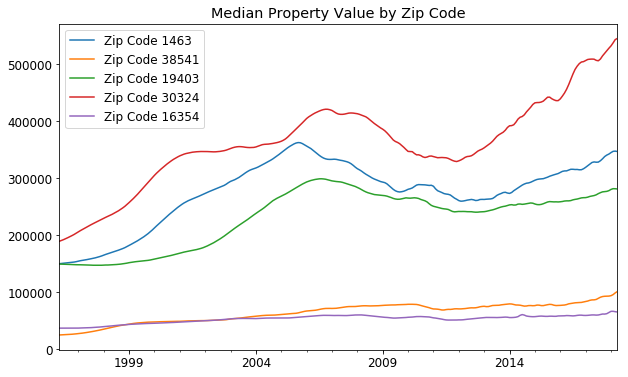

In [40]:
rand_zip_codes=np.random.randint(0,len(df),5) #randomly choosing which rows of the dataframe to use
for i in rand_zip_codes: #graphing the time series for each chosen zip code
    df.iloc[i][7:].plot(figsize=(10,6),label=f"Zip Code {df.iloc[i]['RegionName']}")                        
plt.title("Median Property Value by Zip Code")
plt.legend()
plt.show();

The only conclusion here is that there seems to be an overall increase in value for each zip code.  However, that graph only contains 5 zip codes which is hardly representative. Seems like there was a bump in value around 2006 followed by a drop in 2008 (which tracks with the burst of the housing bubble in 2008) followed by stagnant prices which started rising again in 2012.  Nothing surprising though, since those are all well-known phenomena. 

It also appears that the property values in zip codes with lower medians were not affected as much as the zip codes with higher medians. (That could just be an effect of the scale though, since the higher values are waaaaay higher than the lower ones.)

The pretend company that I'm consulting for is a startup interested in building/owning rental properties.  As they don't have a lot of capital and they're going to buy multiple properties in a zip code to diversify their portfolio/manage risk, I'm going to focus on the lower-priced zip codes and look for the ones that show the most growth within that zip code.  So, to determine which properties are which, I'm just going to grab the maximum value over time from each zip code and then choose the 2nd quartile.

In [14]:
region=[] 
max_values=[]
for i in range(len(df)):  #going through all the different zip codes and finding their maximum values
    max_val=int(df.iloc[i][7:].max())
    region.append(df.RegionName[i])
    max_values.append(max_val)
max_values[:5]

[1033800, 321800, 330000, 1308500, 132300]

In [15]:
max_values_df=pd.DataFrame(max_values,index=region) #creating a dataframe of maximum value for each region
max_values_df.columns=['MaxValues']
max_values_df.describe() #get the one-variable statistics to determine the values for each quartile

,MaxValues
count,1.472300e+04
mean,3.058703e+05
std,3.870530e+05
min,2.220000e+04
25%,1.382000e+05
50%,2.129000e+05
75%,3.533000e+05
max,1.931490e+07


Since I'm just going to pick out the zip codes that are in the 2nd quartile, I need to a dataframe that only has zip codes that have maximum property values between `$138,200` and `$212,900`.

In [16]:
second_quartile=max_values_df.loc[(max_values_df.MaxValues>=138200) & (max_values_df.MaxValues<=212900)]
zipcodes=set(second_quartile.index)
len(zipcodes)

3682

In [17]:
second_quartile.head()

,MaxValues
77084,164300
77449,176200
37013,211900
28269,199700
79912,190100


# Step 4: Reshape from Wide to Long Format

First, I'm going to melt the dataframe to get an overall idea of what the aggregated property values tell me over time.

In [18]:
melted_df=melt_data(df)
len(melted_df)

267

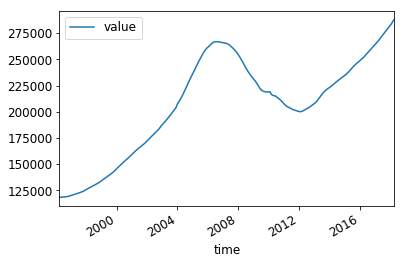

In [19]:
melted_df.iloc[:-2].plot();

This graph confirms my early generalizations: there was a peak in 2008 followed by a drop. Housing prices, in general, started to recover around 2012.

Next, I'm going to melt the dataframe but not aggregate the data, so that I can better see/predict the time series for each zip code.

In [20]:
melted_df2=melt_data2(df) #melting the dataframe but not aggregating the data
len(melted_df2)

3774150

In [21]:
#Narrowing down the melted dataframe to only the 2nd quartile properties
small_melt_df2=melted_df2.loc[melted_df2['RegionName'].isin(zipcodes)]
small_melt_df2.head()

,RegionName,City,State,Metro,CountyName,time,value
5,77084,Houston,TX,Houston,Harris,RegionID,91733.0
8,77449,Katy,TX,Houston,Harris,RegionID,91940.0
14,37013,Nashville,TN,Nashville,Davidson,RegionID,74101.0
24,28269,Charlotte,NC,Charlotte,Mecklenburg,RegionID,69816.0
25,79912,El Paso,TX,El Paso,El Paso,RegionID,93123.0


If a zip code is already stationary, then it's probably not a good one to invest in (since the prices don't tend to rise).  Thus, I'm going to filter out the zip codes that are already stationary.

In [22]:
results=[]
for zipcode in zipcodes:
    region=make_ts(zipcode)
    p=stationarity_check(region) #checking every zipcode in the second quartile to see if its prices are stationary
    results.append((zipcode,p))

Then, I'll sort the results so I can see which zip codes have the lowest p-values (i.e. they're stationary) and which ones have the highest p-values (not stationary).

In [23]:
results.sort(key=lambda x: x[1]) #sorting the results from lowest p-value to highest p-value
results[:10]

[(27939, 6.525700130371681e-05),
 (16001, 0.0001596045240971291),
 (28323, 0.0003186418639155275),
 (29501, 0.0004710778647036037),
 (61614, 0.0006978107720205147),
 (29505, 0.0014528260757557137),
 (32343, 0.0014973225739522548),
 (16061, 0.001971859034568321),
 (43528, 0.0024602657595780898),
 (31757, 0.002514114956332921)]

In [24]:
results[-10:] #the ten highest p-values

[(77036, 0.9990742482499826),
 (38472, 0.9990743862128699),
 (76431, 1.0),
 (76655, 1.0),
 (27980, 1.0),
 (79830, 1.0),
 (15201, 1.0),
 (57035, 1.0),
 (57107, 1.0),
 (49065, 1.0)]

So, I'll drop all of the zip codes that are already stationary (i.e. the ones with a p-value less than 0.05).  It doesn't eliminate a whole lot but it does help narrow it down.

In [25]:
keepers=[x[0] for x in results if x[1]>0.05]
len(keepers)

3545

To confirm that my stationarity check worked, here's a graph of the most stationary zip codes.

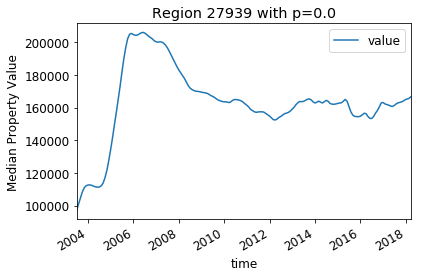

In [26]:
test_region0=make_ts(results[0][0])
test_region0.plot()
plt.title(f"Region {results[0][0]} with p={round(results[0][1],2)}")
plt.ylabel('Median Property Value')
plt.show();

And here's a graph of the most un-stationary zip code.

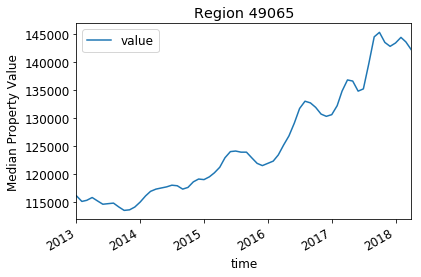

In [27]:
test_region1=make_ts(keepers[-1])
test_region1.plot()
plt.title(f"Region {keepers[-1]}")
plt.ylabel('Median Property Value')
plt.show();

Looks pretty good to me.  I definitely would not invest in the stationary zip code and I would consider investing in the un-stationary one.

I'm going to narrow it down more before I look at creating models because, right now, it'll take a long time to make the models. So, my idea is: the more growth that a property shows in the last few years, the better.  I'll calculate the growth between 2015 and 2018 and choose the 100 largest (because they're growing the most).

In [28]:
growths=[] 
for i in keepers:
    region=make_ts(i)
    rate=growth_rate(region)  #calculating the growth rates for all the 2nd quartile zip codes
    growths.append((i,rate))

In [29]:
growths.sort(key=lambda x: x[1]) #sorting the growth rates to find the top 10 highest
growths[-10:]

[(33952, 0.8498659517426274),
 (32905, 0.8522571819425444),
 (33563, 0.8556566970091027),
 (32117, 0.8831168831168831),
 (32210, 0.8862973760932945),
 (33705, 0.9005649717514125),
 (34982, 0.9022556390977443),
 (32205, 0.9420485175202157),
 (34207, 0.9694002447980417),
 (27980, 1.2055749128919862)]

In [30]:
keepers2=[x[0] for x in growths[-100:]] #keeping the top 100 highest growth rates

In [31]:
#melted dataframe with only my top 100 non-stationary, high growth rate zip codes
smallest_df=melted_df2.loc[melted_df2['RegionName'].isin(keepers2)]

Now that I've narrowed it down to the top 100 un-stationary, high growth rate zip codes, I'm ready to fit ARIMA models to the remaining zip codes.

# Step 5: ARIMA Modeling

Before I fit an ARIMA model, I'm going to manually detrend a time series, to see if it'll make it stationary.

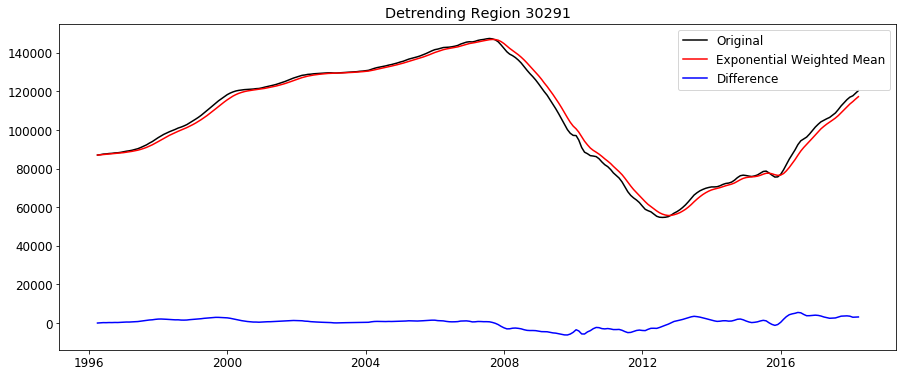

In [32]:
test_region3=make_ts(keepers2[0])
exp_rolmean=test_region3.ewm(halflife=2).mean() #using an exponentially weighted mean to detrend a time series
fig=plt.figure(figsize=(15,6))
orginal=plt.plot(test_region3,color='black',label='Original')
mean=plt.plot(exp_rolmean,color='red',label='Exponential Weighted Mean')
minus=plt.plot(test_region3-exp_rolmean,color='blue',label="Difference")
plt.legend()
plt.title(f"Detrending Region {keepers2[0]}")
plt.show()

In [33]:
stationarity_check(test_region3-exp_rolmean)

0.35777018722677933

It's not totally stationary since the p-value is over 0.05 (and it's pretty obvious from looking at the graph, too. The blue line is not straight.)

Now I'll find and fit the ARIMA models for each zip code, make predictions, determine which predictions have the fastest growth (by calculating the slope between 2018 and 2021).  Then, I'll choose the top ten zip codes to examine in more detail.

In [34]:
results=[]
for keeper in keepers2:
    region_ts=make_ts_small(keeper) #make a time series for the given zip code
    pdq,minAIC=find_arima_parameters(region_ts) #find the best ARIMA parameters
    prediction=fit_arima(region_ts,pdq).predicted_mean #build/fit the model with the "best" parameters
    m=slope(prediction) #find the slope of the predicted values from 2018 to 2021
    results.append((keeper,m)) #add the zipcode and growth to the results list
results.sort(key=lambda x: x[1]) #sort the results
results[-10:] #choose the top ten zip codes

[(33771, 164091.20654813736),
 (33615, 164834.55076339908),
 (15201, 166740.72594597607),
 (37207, 169996.31754379123),
 (33713, 171539.582419831),
 (33755, 172169.2299111767),
 (33710, 180835.12248871726),
 (75233, 205721.09881715293),
 (89030, 211958.24620369598),
 (27980, 344485.476747147)]

Now that I've got the top ten zip codes, I'm going to graph the data, predictions, and confidence intervals for each one so that I can visually examine them to make my final recommendation.  I'll be looking for zip codes with predictions that increase in combination with a having a small confidence interval.  (Having a small confidence interval will make the prediction more certain which minimizes the risk.)  Ideally, the predictions will also be concave up because that indicates that, not only is the value increasing, but it's increasing at a faster rate as time goes on.  Essentially, I'm looking for zip codes with values that are still on the upswing and haven't crossed the point of diminishing returns yet.

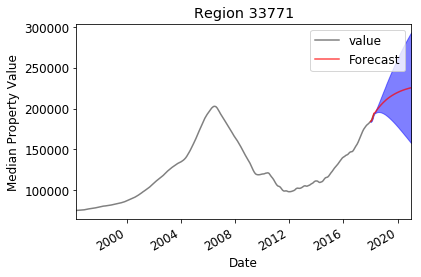

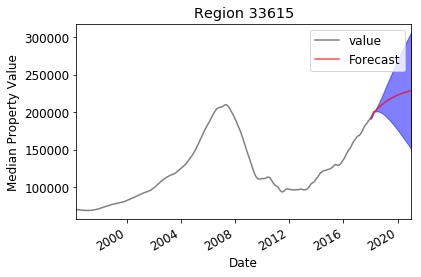

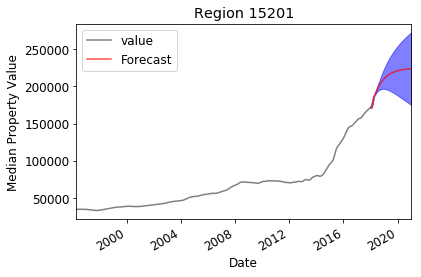

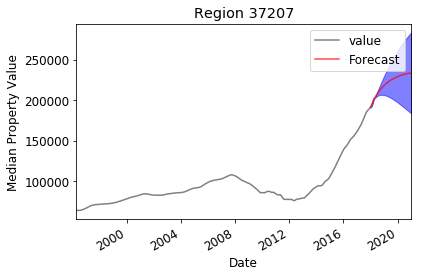

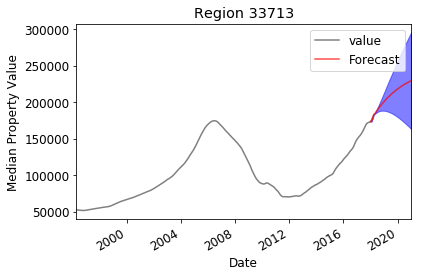

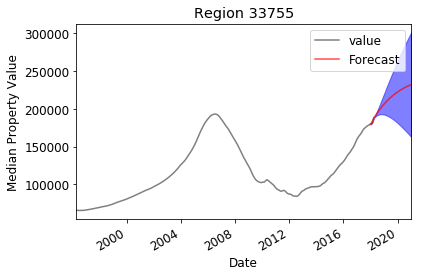

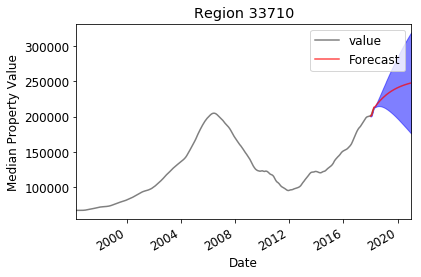

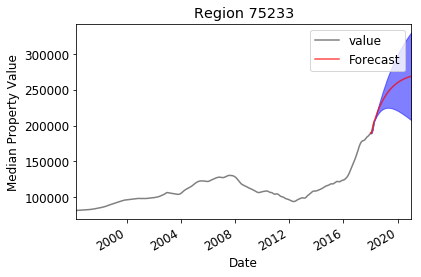

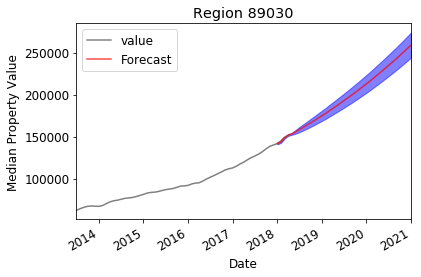

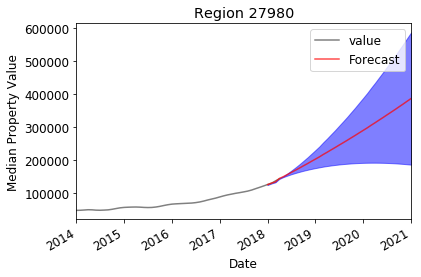

In [35]:
for result in results[-10:]:
    region_ts=make_ts_small(result[0]) #make a time series for the given zip code
    pdq,minAIC=find_arima_parameters(region_ts) #find the best ARIMA parameters
    prediction=fit_arima(region_ts,pdq) #fit the model and make predictions
    plot_prediction(result[0],region_ts,prediction) #graph the results

# Step 6: Interpreting Results

First I narrowed the zip codes down from about 14,000 to about 3700 by focusing on zip codes with property values in the second quartile.  I then looked for properties whose values were already stationary, which narrowed it down to about 3500.  Then, I looked at recent growth rates to further narrow it down to 100 zip codes.  From those 100, I used ARIMA models to predict future growth and then narrowed it down to 10 zip codes. Finally, I graphed those 10 zip codes to visually examine the results.

Zip codes with increasing growth and increasing growth rate (i.e. concave up):
* 89030 - North Las Vegas, NV

Zip codes with increasing growth but contstant growth rate (i.e. linear):
* 27980 - Hertford, NC

Zip codes with increasing growth but decreasing growth rate (i.e. concave down):
* 33771 - Largo, FL
* 33615 - Town 'n' Country, FL
* 15201 - Pittsburgh, PA
* 37207 - Nashville, TN
* 33713 - St. Petersburg, FL
* 33755 - Clearwater, FL
* 33710 - St. Petersburg, FL
* 75233 - Dallas, TX

My recommendation is to for sure 100% invest in zip code 89030.  It's growth rate looks good, it's continuing to increase, and the confidence interval is really small.  I would also recommend investing in 27980 for similar reasons.  The growth rate isn't increasing as much as 89030's but the property values are steadily rising.  Both of those zip codes also have the benefit of having small confidence intervals, which means we can be reasonably sure that their future values will be close to the predictions.  A drawback to zip code 27980 is its proximity to the coast, however, so hurricanes and climate change may be a concern affecting long-term property values.

Of the remaining zip codes, I would recommend 33615, 33713, and 33755.  They've got relatively high slopes between 2018 and 2021 and they're the least concave down (i.e. their growth rates are decreasing but not as quickly as the others). The downside, of course, is that they're all in Florida so climate change and hurricanes may be an issue.

And, if you're the sort of person who likes numbers, this is the predicted growth from 2018 (actual value) to 2021 (predicted value) for each of these zip codes, in order of recommendation:
1. 89030 North Las Vegas, NV: `$141,600.00` --> `$259,241.10` for an increase of `$117,641.10`.  Growth rate: `83.1%`
2. 27980 Hertford, NC: `$126,600.00` --> `$386,599.06` for an increase of `$259,999.06`. Growth rate: `205.4%`
3. 33615 Town 'n' Country, FL: `$191,800.00` --> `$228,724.62` for an increase of `$36,924.62`. Growth rate: `19.3%`
4. 33713 St. Petersburg, FL: `$173,500.00` --> `$229,422.40` for an increase of `$55,922.40`. Growth rate: `32.2%`
5. 33755 Clearwater, FL: `$180,100.00` --> `$232,203.91` for an increase of `$52,103.91`. Growth rate: `28.9%`

Even though the growth rate for 27980 is a lot higher than 89030's growth rate, the confidence interval is a lot wider (which means that the prediction is less sure than 89030...so 89030 is a safer bet).

For future work, it would be interesting to look at which zip codes have the best predictions (lowest AIC's and smallest confidence intervals) and choose recommendations based on that.